In [1]:
#import all required module
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import warnings
from scipy import stats as stats
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler,RobustScaler
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv("E:\Machine Learning\data sets/Advertising.csv",usecols=["TV","Radio","Newspaper","Sales"])
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


 Dependent Feature

In [3]:
df.shape

(200, 4)

In [4]:
df.isnull().sum()  

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

This dataset does not have any Null value

In [5]:
df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [6]:
df.columns[:-1]

Index(['TV', 'Radio', 'Newspaper'], dtype='object')

### Distribution of the feature

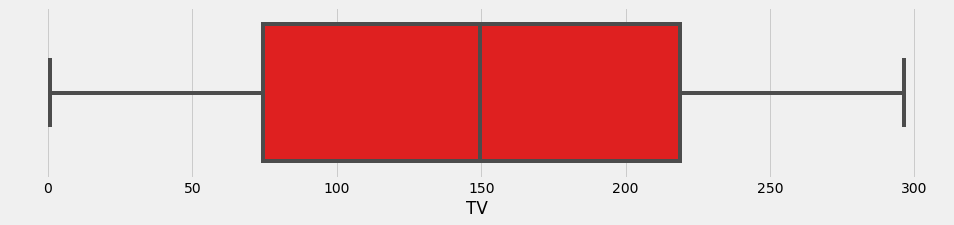

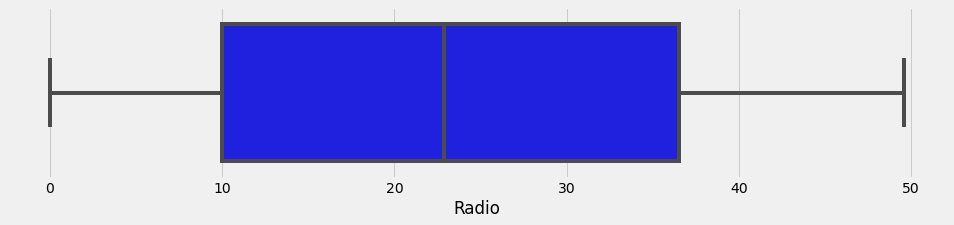

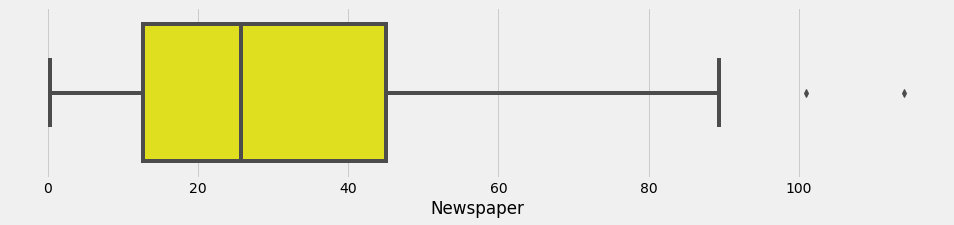

In [7]:
dict = {0:"red",1:"blue",2:"yellow"}
length = len(df.columns[:-1])
for i, j in zip(df.columns[:-1], range(length)):
    plt.figure(figsize=(15,10))
    plt.subplot(3,1,j+1)
    sns.boxplot(df[i],color=dict[j])

The news paper feature has some outliers.

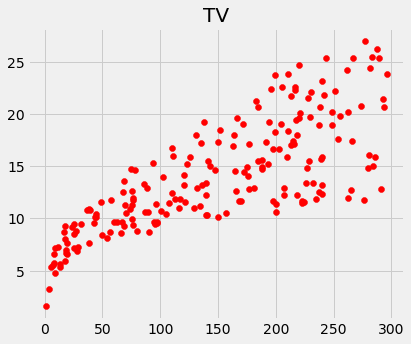

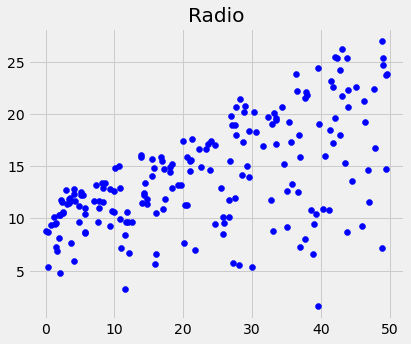

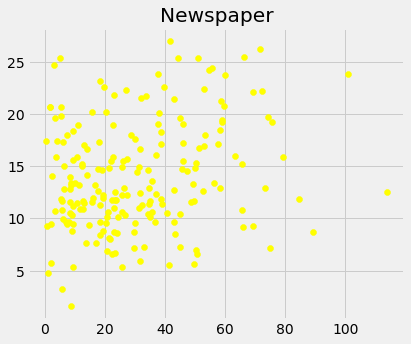

In [8]:
dict = {0:"red",1:"blue",2:"yellow"}
length = len(df.columns[:-1])
for i, j in zip(df.columns[:-1], range(length)):
    plt.figure(figsize=(6,17))
    plt.subplot(3,1,j+1)
    plt.scatter(df[i],df["Sales"],color=dict[j])
    plt.title(i)

Above Distribution says, 

1.Tv feature is co-related with Sales feature both are increasing together.

2.In Radio feature some points are co-related with Sales feature.

3.Newspaper feature distribution is not co-related with Sales feature.Data is spreaded unorder.

In [9]:
def distribution_plot(df,feature):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    df[feature].hist(bins=20)
    plt.title(feature)
    plt.subplot(1,2,2)
    stats.probplot(df[feature],dist="norm",plot=plt)    

TV feature skewness : -0.07
Radio feature skewness : 0.094
Newspaper feature skewness : 0.895
Sales feature skewness : 0.408


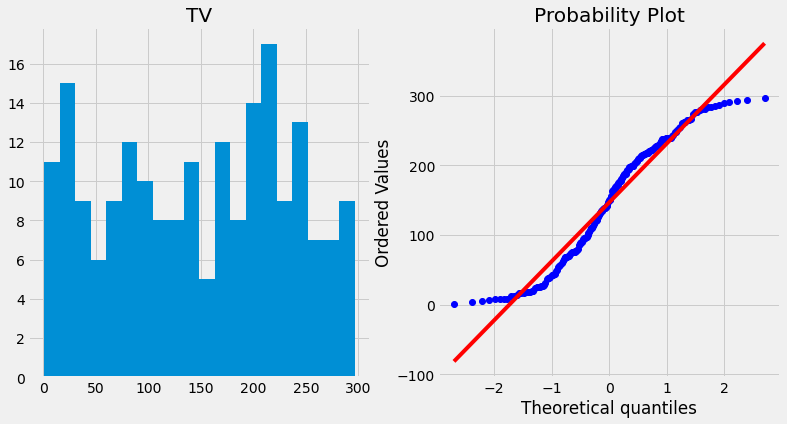

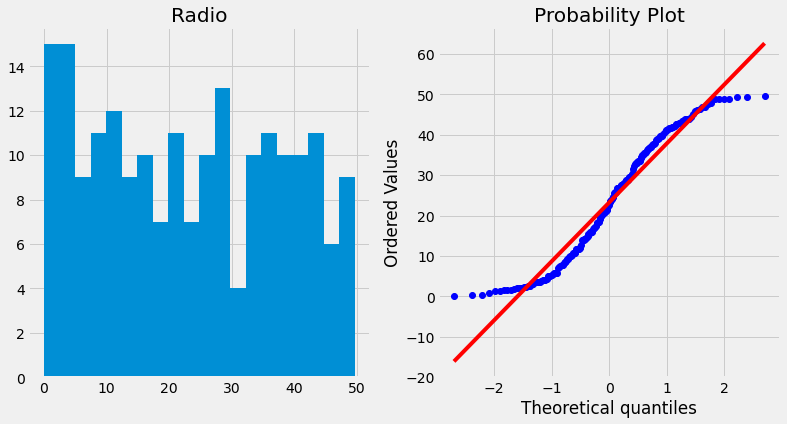

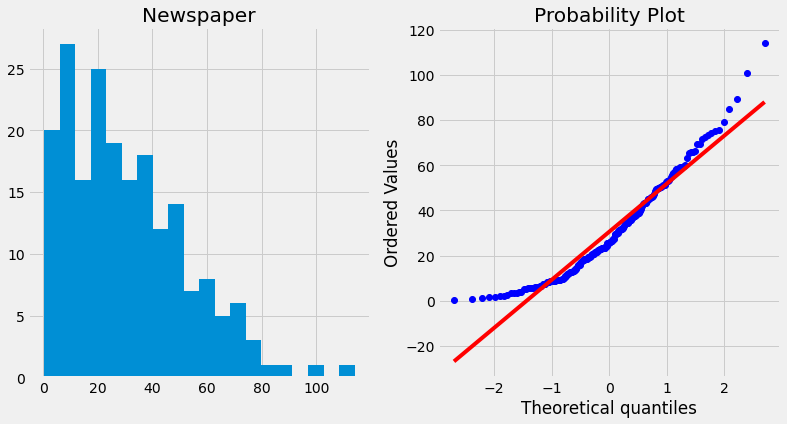

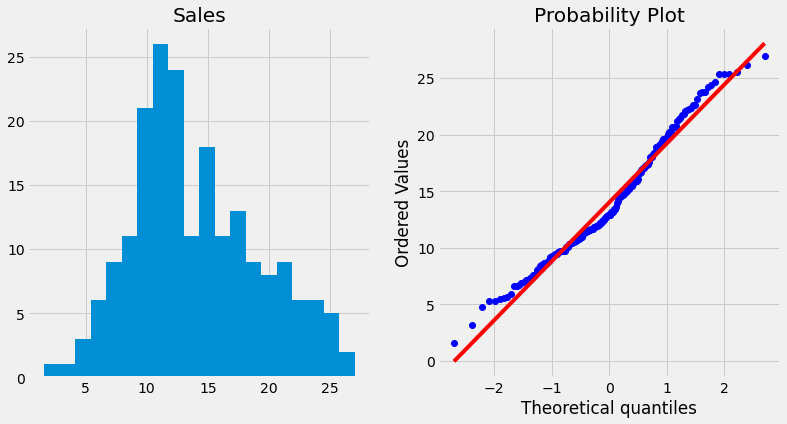

In [10]:
for i in df.columns:
    distribution_plot(df,i)
    print(f"{i} feature skewness : {np.round(df[i].skew(),3)}")

Skew = 3 * (Mean – Median) / Standard Deviation

The Above histogram and Probability diagram shows NewsPaper feature is rightside skewed.

<AxesSubplot:>

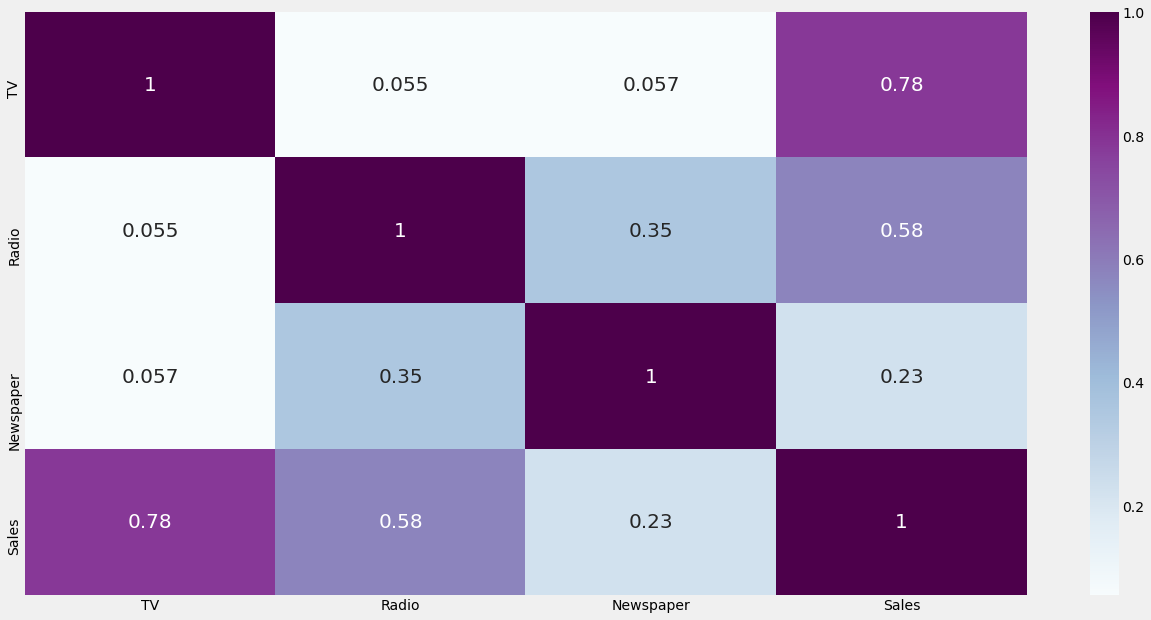

In [11]:
plt.figure(figsize=(20,10))     
sns.heatmap(df.corr(),cmap="BuPu",annot=True,annot_kws={"size":20})

Output feature is literally correlated with the Tv and Radio Feature.

## Hypothesis Testing 
### To Confirm how much features are Correlated with output feature

In [12]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
for i in df.iloc[:,:-1]:
    stat,p = spearmanr(df[i],df["Sales"])
    print(f"p-value for {i} : {p}")
    print("")
    if p > 0.05:
        print(f"{i} feature has independent relationship with sales")
    else:
        print(f"{i} feature has dependent relationship with sales")
        
    print("")
    print("")

p-value for TV : 6.3792345734183446e-46

TV feature has dependent relationship with sales


p-value for Radio : 1.6651706375166126e-17

Radio feature has dependent relationship with sales


p-value for Newspaper : 0.005676351421789337

Newspaper feature has dependent relationship with sales




## Feature Engineering

### Guassian Transformation

 boxcox_transformation applied in Newspaper feature skewness :-0.078 


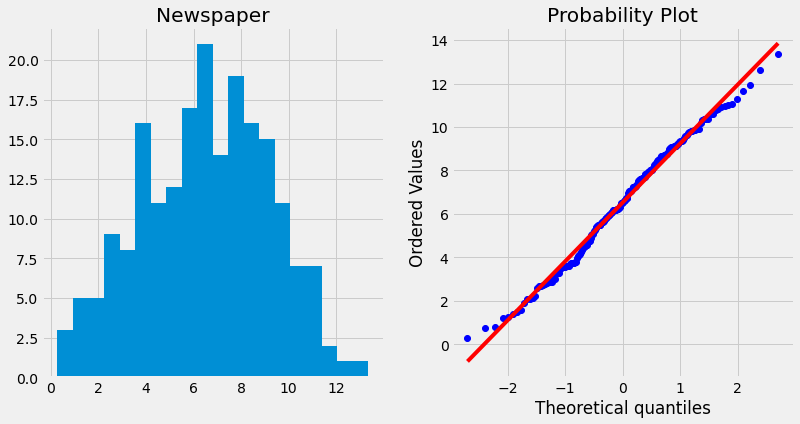

In [13]:
from scipy.special import boxcox1p
df["Newspaper"],params = stats.boxcox(df["Newspaper"]+1)
distribution_plot(df,"Newspaper")
skw = df["Newspaper"].skew()
print(f" boxcox_transformation applied in Newspaper feature skewness :{round(skw,3)} ")

I have already tried all Guassian Distribution Transformation,Boxcox transformation will give the best result compared to other transformation.

<AxesSubplot:xlabel='Newspaper'>

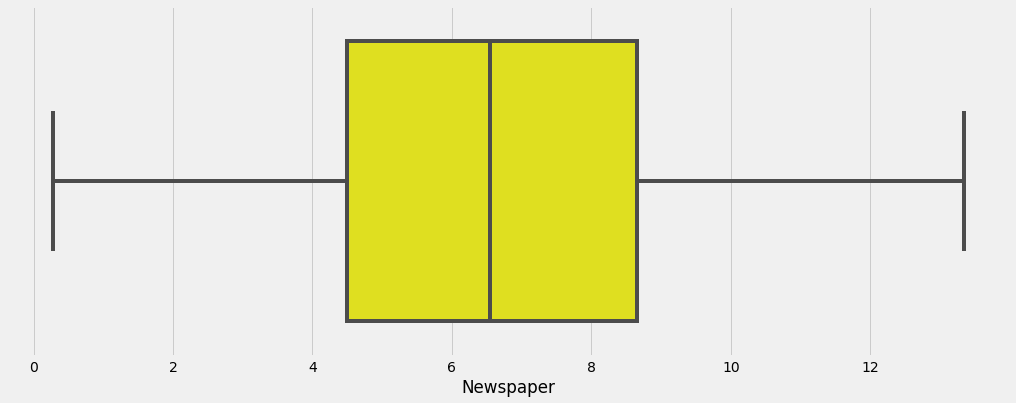

In [14]:
plt.figure(figsize=(16,6))
sns.boxplot(df["Newspaper"],color="yellow")

Outliers has been handled by Boxcox Transformation.

### Data Transformation

In [15]:
scale = StandardScaler()   
df_std = scale.fit_transform(df.iloc[:,:-1]) 

In [16]:
rb_scale = RobustScaler()
df_rb =  rb_scale.fit_transform(df.iloc[:,:-1])

In [17]:
#x = df_std[:,:-1]
#y = df_std[:,-1]
x = df_rb[:,:]
y = df.iloc[:,-1].values

In [18]:
#x = df_std[:,:-1]
#y = df_std[:,-1]
#x = df_rb[:,:-1]
#y = df_rb[:,-1]

In [68]:
import pickle
pickle_out = open("rb.pkl","wb")
pickle.dump(rb_scale, pickle_out)
pickle_out.close()

In [19]:
Testing_R2_Score =[]
Training_MSE = []
Testing_MSE = []
Testing_MAE = []
Residual_sum_of_squares = []
Model = []
cros_val_scr = []

In [20]:
def prediction(x_train,x_test,y_train,y_test,model,algo):        
        print(f"predictions for {algo} Algorithem")
        Model.append(algo)        
        print("Train Results: ")
        print("================")
        pre = model.predict(x_train)
        print("        Training R2 Score : {:.2f} %".format((metrics.r2_score(y_train,pre))*100))
        print("")
        print("        Training Mean Absolute Error : {:.4f} ".format((metrics.mean_absolute_error(y_train,pre))))
        print("")       
        print("        Training Mean Squared Error : {:.4f} ".format((metrics.mean_squared_error(y_train,pre))))
        print("")
        print("")
        Training_MSE.append(round(metrics.mean_squared_error(y_train,pre),3))
        print("Test Results: ")
        print("================")
        pre_t = model.predict(x_test)
        print("        Testing R2 Score : {:.2f} %".format((metrics.r2_score(y_test,pre_t))*100))
        print("")        
        print("        Testing Mean Absolute Error : {:.4f} ".format((metrics.mean_absolute_error(y_test,pre_t))))
        print("")        
        print("        Testing Mean Squared Error : {:.4f} ".format((metrics.mean_squared_error(y_test,pre_t))))
        print("")
        print("        Residual sum of squares: {:.6f}".format(np.mean(pre_t - y_test) ** 2))
        
        Testing_R2_Score.append(round((metrics.r2_score(y_test,pre_t)*100),2))
        Testing_MSE.append(round(metrics.mean_squared_error(y_test,pre_t),3))
        Residual_sum_of_squares.append(round((np.mean(pre_t - y_test) ** 2),6))
        Testing_MAE.append(round(metrics.mean_absolute_error(y_test,pre_t),3))


In [21]:
def cvs(x,y,model,algo):
    cv = cross_val_score(model,x,y,cv=5)
    print(f"Cross validation Score for {algo} : {round(cv.mean()*100,2)} %")
    cros_val_scr.append(round((cv.mean()*100),2))
               

In [22]:
color = ["#FF7300","#52D726","#FF0000","gold","#007ED6","#7CDDDD","#007ED6","#FF0000","teal",]
import random
def scatter(x_test,y_test,model,algo):
    global count
    plt.figure(figsize=(15,6))
    plt.style.use("fivethirtyeight")
    plt.scatter(y_test,model.predict(x_test),c=random.choice(color),s=80)
    plt.title(f"Prediction for {algo} Model")
    plt.xlabel('Y Test')
    plt.ylabel('Predicted Y')
    plt.show()


In [23]:
def plot(x_test,y_test,model,algo):
    plt.figure(figsize=(14,6))
    plt.style.use("seaborn-bright")
    plt.plot(y_test,label ='Test')
    plt.plot(model.predict(x_test), label = 'prediction')
    plt.title(f"Comparision between Prediction and Test data by {algo} Model")
    plt.legend()
    plt.show()

## Split Data

In [24]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)   

In [25]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(150, 3)
(50, 3)
(150,)
(50,)


## Model Evaluation

## Linear Regression_1

In [26]:
lr = LinearRegression()
lr.fit(x_train,y_train)
algo= "Linear Regression_1"

In [27]:
prediction(x_train,x_test,y_train,y_test,lr,algo)

predictions for Linear Regression_1 Algorithem
Train Results: 
        Training R2 Score : 90.72 %

        Training Mean Absolute Error : 1.2254 

        Training Mean Squared Error : 2.4389 


Test Results: 
        Testing R2 Score : 85.80 %

        Testing Mean Absolute Error : 1.2984 

        Testing Mean Squared Error : 4.0035 

        Residual sum of squares: 0.012998


In [28]:
cvs(x,y,lr,algo)

Cross validation Score for Linear Regression_1 : 88.74 %


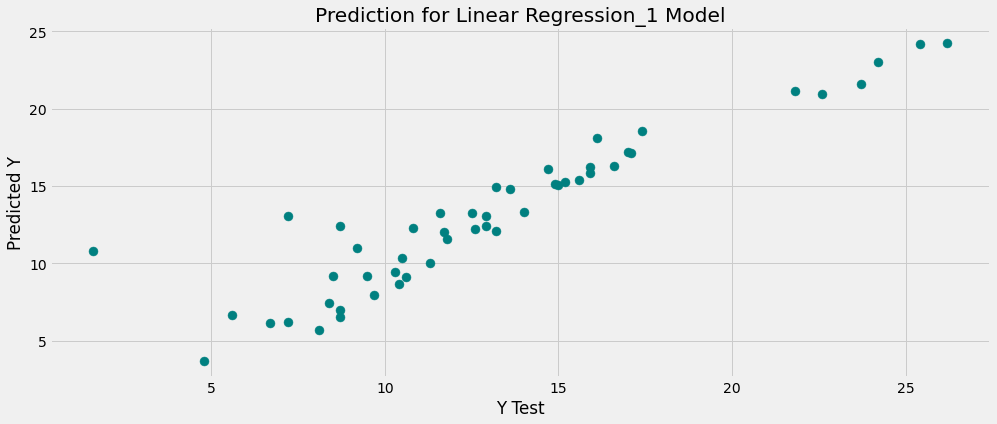

In [29]:
scatter(x_test,y_test,lr,algo)

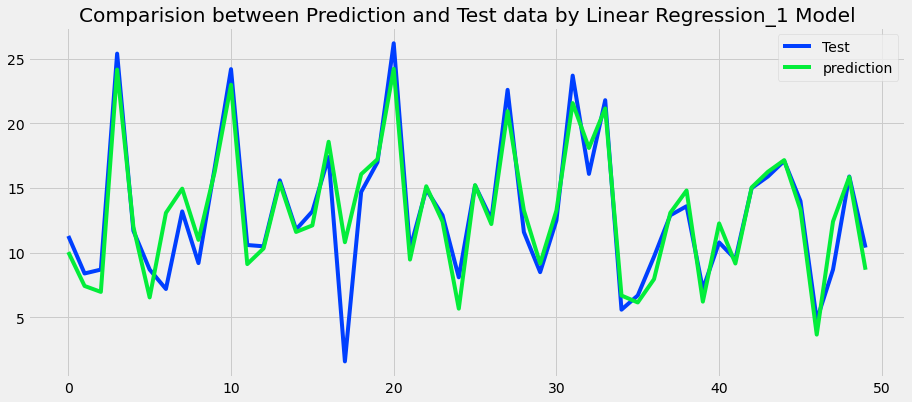

In [30]:
plot(x_test,y_test,lr,algo)

Compared to Standared Scalaer, Robust Scaler is performed well in this situation.

## Feature selection

Weights of the Features : [6.38084346 5.28609767 0.03588377]
Slope or Rotation of the Theta : 14.098226864199576


<BarContainer object of 3 artists>

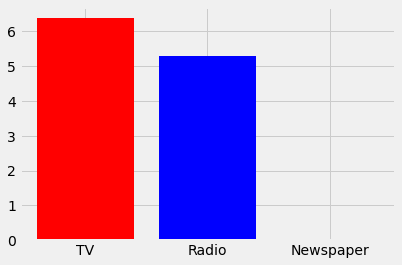

In [31]:
print(f"Weights of the Features : {lr.coef_}")
print(f"Slope or Rotation of the Theta : {lr.intercept_}")

weights = lr.coef_
plt.bar(df.columns[:-1],weights,color=["red","blue","yellow"])


Above result says,Newspaper feature importance is nearly to Zero.So we can eliminate the newspaper feature.

In [32]:
y

array([22.1, 10.4,  9.3, 18.5, 12.9,  7.2, 11.8, 13.2,  4.8, 10.6,  8.6,
       17.4,  9.2,  9.7, 19. , 22.4, 12.5, 24.4, 11.3, 14.6, 18. , 12.5,
        5.6, 15.5,  9.7, 12. , 15. , 15.9, 18.9, 10.5, 21.4, 11.9,  9.6,
       17.4,  9.5, 12.8, 25.4, 14.7, 10.1, 21.5, 16.6, 17.1, 20.7, 12.9,
        8.5, 14.9, 10.6, 23.2, 14.8,  9.7, 11.4, 10.7, 22.6, 21.2, 20.2,
       23.7,  5.5, 13.2, 23.8, 18.4,  8.1, 24.2, 15.7, 14. , 18. ,  9.3,
        9.5, 13.4, 18.9, 22.3, 18.3, 12.4,  8.8, 11. , 17. ,  8.7,  6.9,
       14.2,  5.3, 11. , 11.8, 12.3, 11.3, 13.6, 21.7, 15.2, 12. , 16. ,
       12.9, 16.7, 11.2,  7.3, 19.4, 22.2, 11.5, 16.9, 11.7, 15.5, 25.4,
       17.2, 11.7, 23.8, 14.8, 14.7, 20.7, 19.2,  7.2,  8.7,  5.3, 19.8,
       13.4, 21.8, 14.1, 15.9, 14.6, 12.6, 12.2,  9.4, 15.9,  6.6, 15.5,
        7. , 11.6, 15.2, 19.7, 10.6,  6.6,  8.8, 24.7,  9.7,  1.6, 12.7,
        5.7, 19.6, 10.8, 11.6,  9.5, 20.8,  9.6, 20.7, 10.9, 19.2, 20.1,
       10.4, 11.4, 10.3, 13.2, 25.4, 10.9, 10.1, 16

In [33]:
x = df_rb[:,:-1]
y = df.iloc[:,-1].values

In [34]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)

In [35]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(150, 2)
(50, 2)
(150,)
(50,)


## Linear Regression_2

In [36]:
lr_new = LinearRegression()
lr_new.fit(x_train,y_train)
algo= "Linear Regression_2"
prediction(x_train,x_test,y_train,y_test,lr_new,algo)

predictions for Linear Regression_2 Algorithem
Train Results: 
        Training R2 Score : 90.72 %

        Training Mean Absolute Error : 1.2250 

        Training Mean Squared Error : 2.4394 


Test Results: 
        Testing R2 Score : 85.81 %

        Testing Mean Absolute Error : 1.2947 

        Testing Mean Squared Error : 3.9999 

        Residual sum of squares: 0.012332


In [37]:
cvs(x,y,lr_new,algo)

Cross validation Score for Linear Regression_2 : 88.93 %


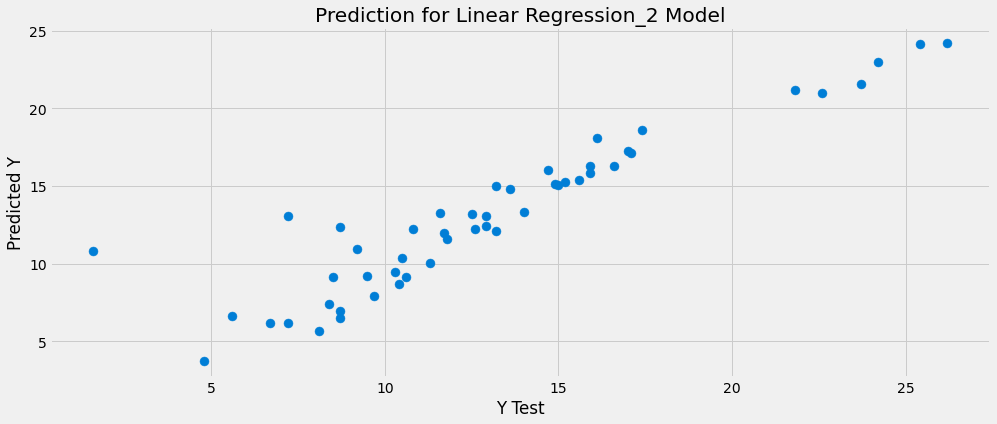

In [38]:
scatter(x_test,y_test,lr_new,algo)

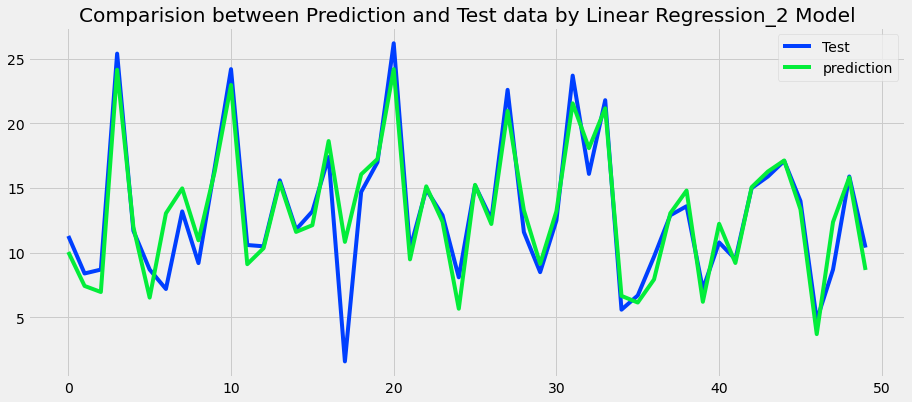

In [39]:
plot(x_test,y_test,lr_new,algo)

## Gradient Boosting Regressor

In [40]:
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(x_train,y_train)
algo= "Gradient Boosting Regressor"
prediction(x_train,x_test,y_train,y_test,gbr,algo)

predictions for Gradient Boosting Regressor Algorithem
Train Results: 
        Training R2 Score : 99.87 %

        Training Mean Absolute Error : 0.1421 

        Training Mean Squared Error : 0.0351 


Test Results: 
        Testing R2 Score : 96.68 %

        Testing Mean Absolute Error : 0.6687 

        Testing Mean Squared Error : 0.9371 

        Residual sum of squares: 0.000293


In [41]:
cvs(x,y,gbr,algo)

Cross validation Score for Gradient Boosting Regressor : 97.83 %


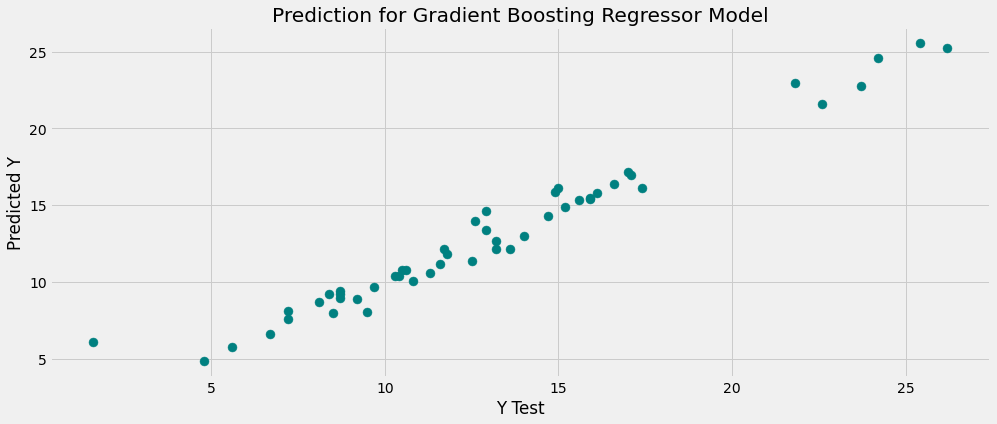

In [42]:
scatter(x_test,y_test,gbr,algo)

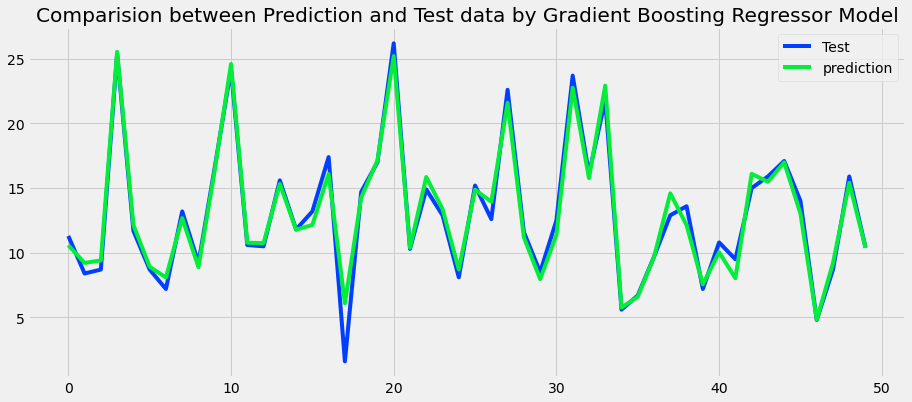

In [43]:
plot(x_test,y_test,gbr,algo)

## Ada Boost Regressor

In [44]:
abr = AdaBoostRegressor(random_state=0)
abr.fit(x_train,y_train)
algo= "Ada Boost Regressor"
prediction(x_train,x_test,y_train,y_test,abr,algo)

predictions for Ada Boost Regressor Algorithem
Train Results: 
        Training R2 Score : 97.96 %

        Training Mean Absolute Error : 0.5917 

        Training Mean Squared Error : 0.5375 


Test Results: 
        Testing R2 Score : 95.03 %

        Testing Mean Absolute Error : 0.9429 

        Testing Mean Squared Error : 1.4014 

        Residual sum of squares: 0.015560


In [45]:
cvs(x,y,abr,algo)

Cross validation Score for Ada Boost Regressor : 95.41 %


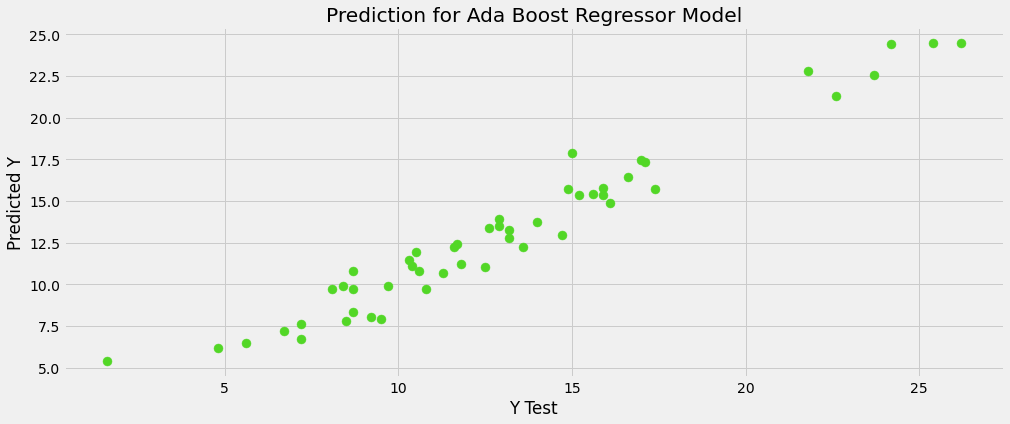

In [46]:
scatter(x_test,y_test,abr,algo)

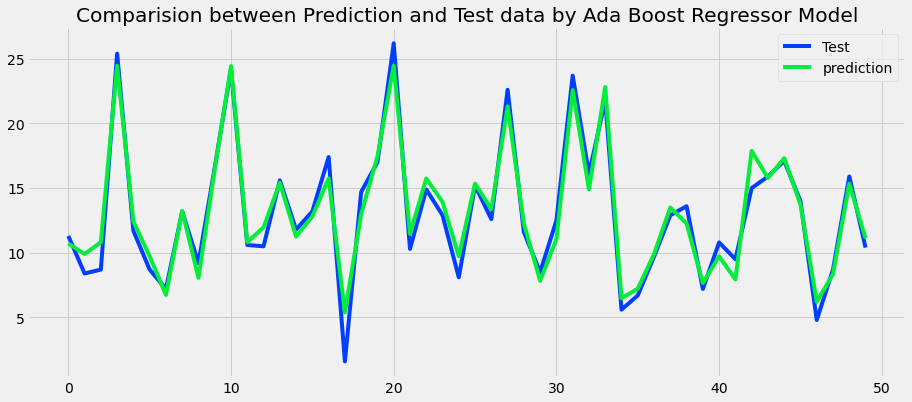

In [47]:
plot(x_test,y_test,abr,algo)

## Random Forest Regressor

In [48]:
rfr = RandomForestRegressor(random_state=0)
rfr.fit(x_train,y_train)
algo= "Random Forest Regressor"
prediction(x_train,x_test,y_train,y_test,rfr,algo)

predictions for Random Forest Regressor Algorithem
Train Results: 
        Training R2 Score : 99.76 %

        Training Mean Absolute Error : 0.1957 

        Training Mean Squared Error : 0.0633 


Test Results: 
        Testing R2 Score : 96.85 %

        Testing Mean Absolute Error : 0.6584 

        Testing Mean Squared Error : 0.8886 

        Residual sum of squares: 0.000086


In [49]:
cvs(x,y,rfr,algo)

Cross validation Score for Random Forest Regressor : 97.77 %


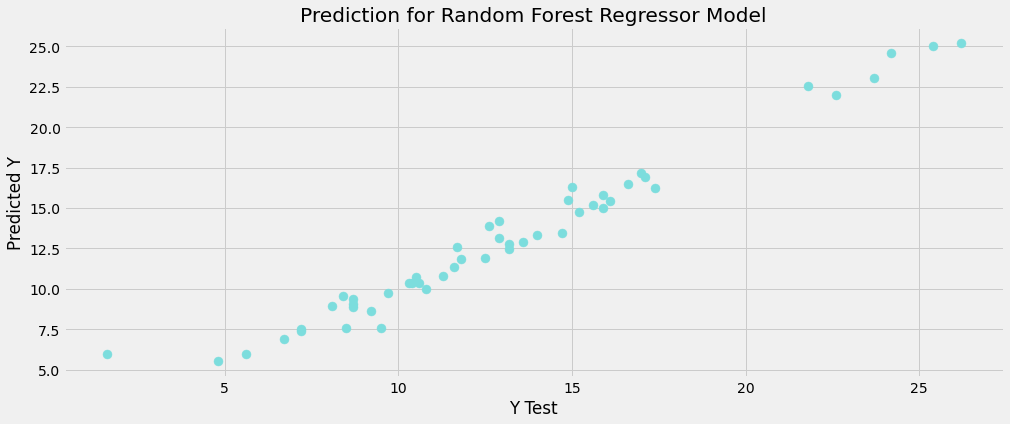

In [50]:
scatter(x_test,y_test,rfr,algo)

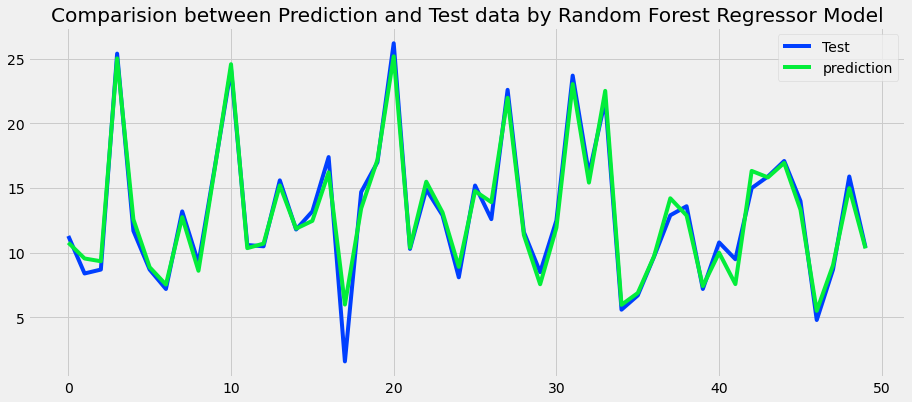

In [51]:
plot(x_test,y_test,rfr,algo)

## Support Vector Regressor

In [52]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(x_train,y_train)
algo= "Support Vector Regressor"
prediction(x_train,x_test,y_train,y_test,svr,algo)

predictions for Support Vector Regressor Algorithem
Train Results: 
        Training R2 Score : 96.75 %

        Training Mean Absolute Error : 0.5354 

        Training Mean Squared Error : 0.8547 


Test Results: 
        Testing R2 Score : 92.48 %

        Testing Mean Absolute Error : 0.7802 

        Testing Mean Squared Error : 2.1207 

        Residual sum of squares: 0.030596


In [53]:
cvs(x,y,svr,algo)

Cross validation Score for Support Vector Regressor : 95.65 %


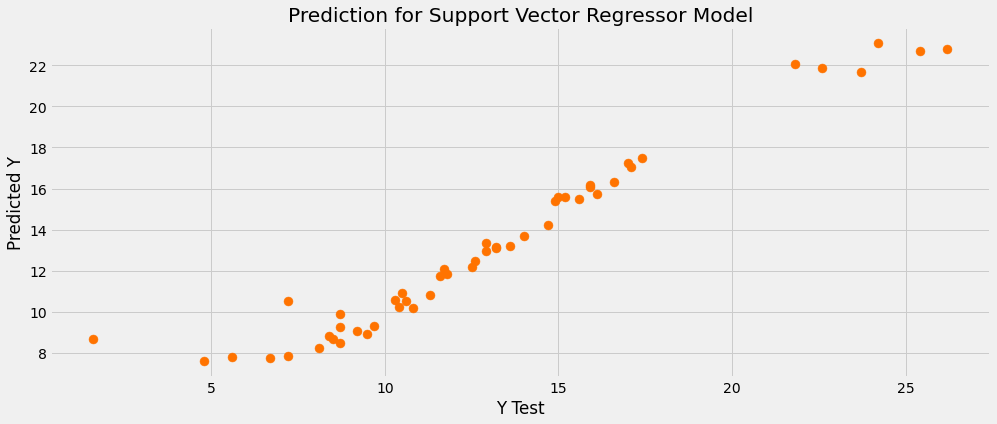

In [54]:
scatter(x_test,y_test,svr,algo)

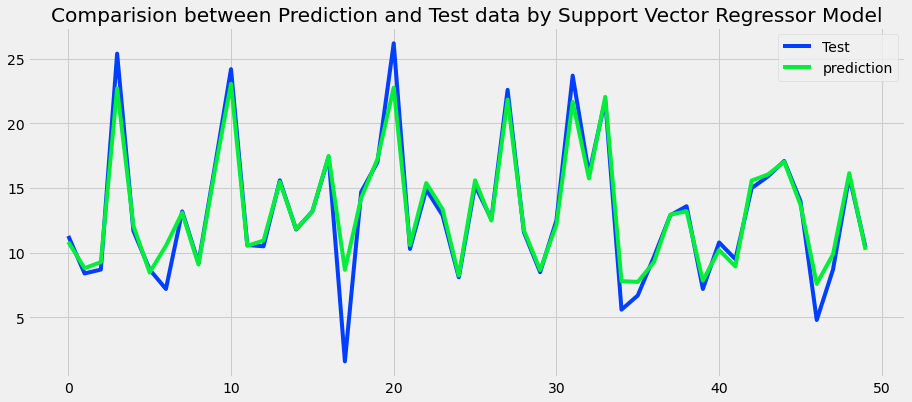

In [55]:
plot(x_test,y_test,svr,algo)

## Comparing the models

In [56]:
results = {"Model":Model,"Testing_R2_Score":Testing_R2_Score,
           "cros_val_scr":cros_val_scr,"Training_MSE":Training_MSE,"Testing_MSE":Testing_MSE,
          "Testing_MAE":Testing_MAE,"Residual_sum_of_squares":Residual_sum_of_squares}

df = pd.concat([pd.Series(v,name=k) for k,v in results.items()],axis=1)
df.set_index("Model",inplace=True)
df

,Testing_R2_Score,cros_val_scr,Training_MSE,Testing_MSE,Testing_MAE,Residual_sum_of_squares
Model,,,,,,
Linear Regression_1,85.80,88.74,2.439,4.003,1.298,0.012998
Linear Regression_2,85.81,88.93,2.439,4.000,1.295,0.012332
Gradient Boosting Regressor,96.68,97.83,0.035,0.937,0.669,0.000293
Ada Boost Regressor,95.03,95.41,0.537,1.401,0.943,0.015560
Random Forest Regressor,96.85,97.77,0.063,0.889,0.658,0.000086
Support Vector Regressor,92.48,95.65,0.855,2.121,0.780,0.030596


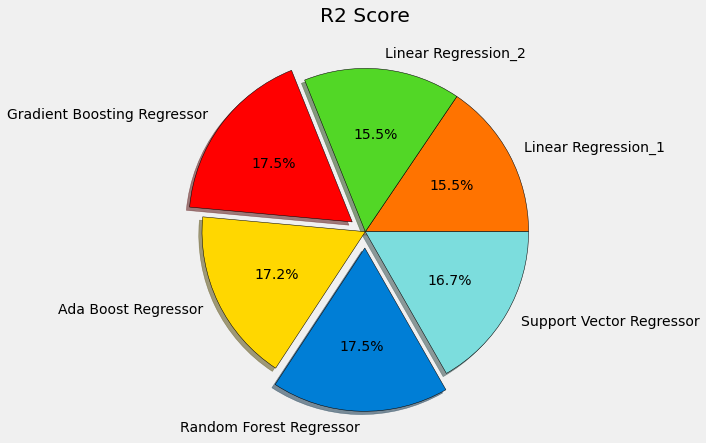

In [57]:
res = []
for i in Testing_R2_Score:
    val = round(i/np.sum(Testing_R2_Score),4)
    res.append(val)

label = [i for i in Model]
color = ["#FF7300","#52D726","#FF0000","gold","#007ED6","#7CDDDD"]
plt.figure(figsize=(12,7))
plt.style.use("fivethirtyeight")
explode = [0.0,0.0,0.1,0.0,0.1,0.0]
plt.pie(res,labels=label,colors=color,explode=explode,autopct="%1.1f%%",
        shadow=True,wedgeprops={"edgecolor":"black"})
plt.title("R2 Score")
plt.show()

Gradient boost regrassor & random forest regressor both models are giving nearly same result.

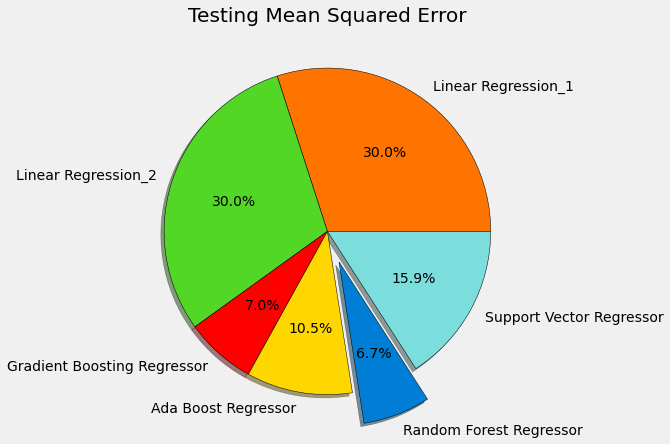

In [58]:
res = []
for i in Testing_MSE:
    val = round(i/np.sum(Testing_MSE),4) 
    res.append(val) 

label = [i for i in Model]
color = ["#FF7300","#52D726","#FF0000","gold","#007ED6","#7CDDDD"]
plt.figure(figsize=(12,7))
plt.style.use("fivethirtyeight")
explode = [0.0,0.0,0.0,0.0,0.2,0.0]
plt.pie(res,labels=label,colors=color,explode=explode,autopct="%1.1f%%",
        shadow=True,wedgeprops={"edgecolor":"black"})
plt.title("Testing Mean Squared Error")
plt.show()

Random Forest Regressor giving less error result comparing to gradient boost regressor &also cross validation score is high,so we took Random Forest Regressor for further steps.

## Hyper parameter tuning 

In [59]:
rfr = RandomForestRegressor()
parameters = {'n_estimators':[80,100,150,200,250], 'min_samples_split':[1,2,5,6],
              'max_depth':[10,20,25,30,35],'bootstrap': [True, False],
              'min_samples_leaf': [1,2,3,4]}
grid = GridSearchCV(rfr,parameters,cv=4,n_jobs=-1)
grid.fit(x_train, y_train)
print ("r2 / variance : ", grid.best_score_)

r2 / variance :  0.9786039018132283


In [60]:
grid.best_params_

{'bootstrap': True,
 'max_depth': 35,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [61]:
algo = "Random Forest Regressor HPT"
prediction(x_train,x_test,y_train,y_test,grid,algo)

predictions for Random Forest Regressor HPT Algorithem
Train Results: 
        Training R2 Score : 99.74 %

        Training Mean Absolute Error : 0.2052 

        Training Mean Squared Error : 0.0687 


Test Results: 
        Testing R2 Score : 96.84 %

        Testing Mean Absolute Error : 0.6526 

        Testing Mean Squared Error : 0.8898 

        Residual sum of squares: 0.000699


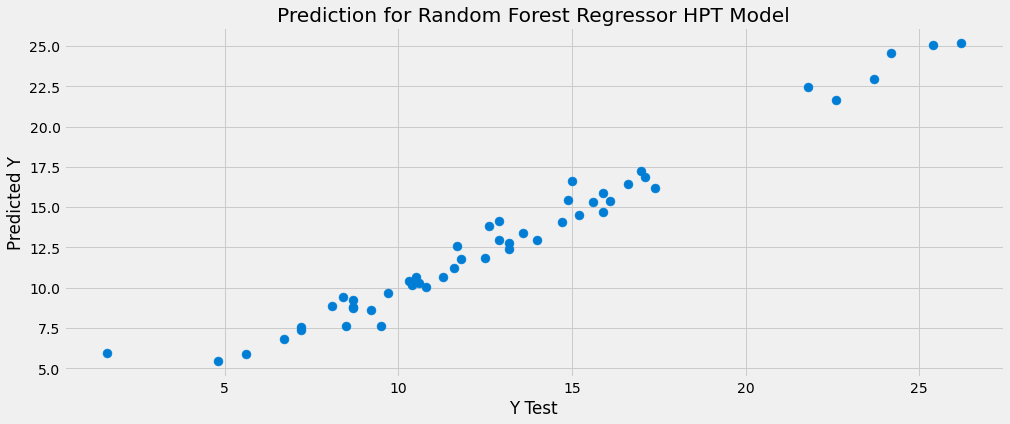

In [62]:
scatter(x_test,y_test,grid,algo)

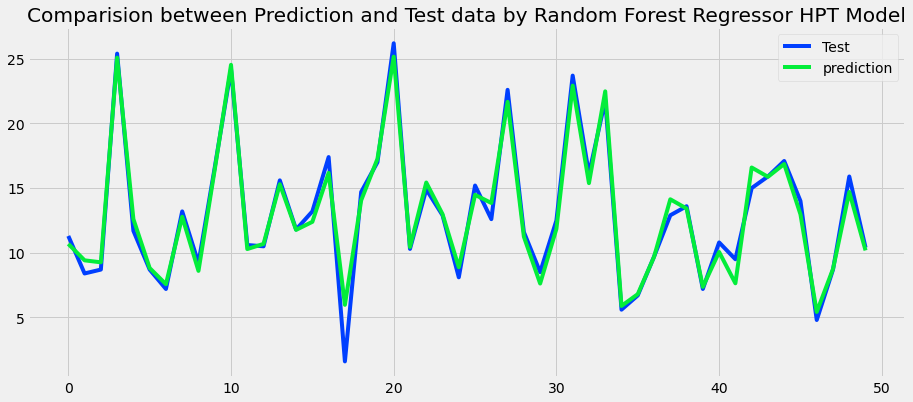

In [63]:
plot(x_test,y_test,grid,algo)

In [65]:
pre = grid.predict(x_test)

In [266]:
import pickle
pickle_out = open("advertising_model.pkl","wb")
pickle.dump(grid, pickle_out)
pickle_out.close()

## Evaluation metrics

In [66]:
print(f"Explained Variance Socre : {round(metrics.explained_variance_score(pre,y_test)*100,4)}")
print(f"Max Error                : {metrics.max_error(pre,y_test)}")
print(f"Root Mean Squared Error  : {round(np.sqrt(metrics.mean_squared_error(pre,y_test)),4)}")

Explained Variance Socre : 96.4843
Max Error                : 4.374999999999998
Root Mean Squared Error  : 0.9433


Random forest regressor is given good result compared to other Model.